# Build CNN base modle for detect pneumonia type in human lungs.

## 1) install required libraries

In [ ]:
# Import modules and packages
import numpy as np
import pandas as pd
import itertools
import os, stat, time
from os.path import dirname as up

import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from keras.metrics import categorical_crossentropy
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.convolutional import *
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD

from matplotlib import pyplot as plt

from sklearn.metrics import confusion_matrix

from vb100_utils import *
from shutil import copyfile
import shutil
import glob
from PIL import Image

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
!pip install sklearn
!pip install -U matplotlib
!pip install Pillow

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 100.9 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1


In [ ]:
print('Tensorflow version = {}'.format(tf.__version__))
print('Keras version = {}'.format(keras.__version__))

Tensorflow version = 2.17.0
Keras version = 3.4.1


In [ ]:
pip install numpy pandas tensorflow matplotlib scikit-learn pillow


In [ ]:
!pip install vb100_utils


ERROR: Could not find a version that satisfies the requirement vb100_utils (from versions: none)
ERROR: No matching distribution found for vb100_utils


In [ ]:
## Import modules and packages
import numpy as np
import pandas as pd
import itertools
import os, stat, time
from os.path import dirname as up

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization

from matplotlib import pyplot as plt

from sklearn.metrics import confusion_matrix

#from vb100_utils import *  # Ensure that vb100_utils is available in your project
import sys
sys.path.append('/content/vb100_utils.py') # replace with actual path
from vb100_utils import *

from shutil import copyfile
import shutil
import glob
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

# %matplotlib inline  # This is typically used in Jupyter notebooks; remove it if running outside of a notebook


In [ ]:
print('Tensorflow version = {}'.format(tf.__version__))
print('Keras version = {}'.format(tf.keras.__version__))

Tensorflow version = 2.17.0
Keras version = 3.4.1


In [ ]:
!pip install tensorflow keras kaggle

## 2) Download data set from kaggle

In [ ]:
!pip install -q kaggle


In [ ]:
# Download the dataset from Kaggle
!kaggle datasets download -d sriramr/paultimothymooney/chest-xray-pneumonia

#Unzip the downloaded file
!unzip -q chest-xray-pneumonia.zip -d /content/dataset

403 - Forbidden - Permission 'datasets.get' was denied
unzip:  cannot find or open chest-xray-pneumonia.zip, chest-xray-pneumonia.zip.zip or chest-xray-pneumonia.zip.ZIP.


In [ ]:
!pip install opendatasets -q
import opendatasets as od
od.download("https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: akmaljakamal
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia


100%|██████████| 2.29G/2.29G [01:51<00:00, 22.2MB/s]


In [ ]:
# CONSTANTS FOR DIRECTORIES
TRAIN_DIR = 'chest-xray-pneumonia/chest_xray/chest_xray/train'
VALID_DIR = 'chest-xray-pneumonia/chest_xray/chest_xray/val'
TEST_DIR = 'chest-xray-pneumonia/chest_xray/chest_xray/test'
l_DIRS = [TRAIN_DIR, VALID_DIR, TEST_DIR]
POSITIVE_CLASS = 'NORMAL'
ABSTRACT_CLASS = 'PNEUMONIA'

# CONSTANTS FOR IMAGE PARAMETERS
INPUT_W = 1200 # pixels
INPUT_H = 900  # pixels
DIVIDER = 3.6
INPUT_DIM = (int(INPUT_W/DIVIDER), int(INPUT_H/DIVIDER), 1)
BATCH_SIZE_TRAIN = 64
BATCH_SIZE_TEST = 64
BATCH_SIZE_VALID = 16
NORMALIZER = 1./255
IMAGE_FORMAT = 'jpeg'

# Output Info
print('Image dimmensions for CNN = {}'.format(INPUT_DIM))

Image dimmensions for CNN = (333, 250, 1)


In [ ]:
if abstract_class_exists(ABSTRACT_CLASS, l_DIRS):
    structure_origin_data(l_DIRS, IMAGE_FORMAT, POSITIVE_CLASS)

classes = classes_for_each_set(l_DIRS)

print('Catched classes for the model:\n{}'.format(classes))

Performing raw data restructuring. Please wait.

Current Working Directory: /content

*** Handling workspace: chest-xray-pneumonia/chest_xray/chest_xray/train ***
| Folders found:
|| ['/content/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA', '/content/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL']

| Entering to: /content/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA
||| Unique Classes Found: ['BACTERIA', 'VIRUS']
||| Files found in total: 3875
--> BACTERIA = 2530
|||--> Filelist for BACTERIA is created.
|||| Successfully created the directory for BACTERIA on /content/chest-xray-pneumonia/chest_xray/chest_xray/train/BACTERIA
--> VIRUS = 1345
|||--> Filelist for VIRUS is created.
|||| Successfully created the directory for VIRUS on /content/chest-xray-pneumonia/chest_xray/chest_xray/train/VIRUS

| Entering to: /content/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL
||| Unique Classes Found: ['NORMAL']
||| Files found in total: 1341
--> NORMA

Found 5216 images belonging to 3 classes.
Found 624 images belonging to 3 classes.
Found 16 images belonging to 2 classes.


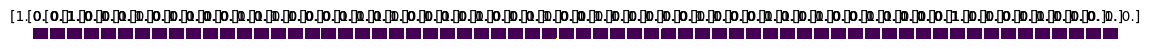

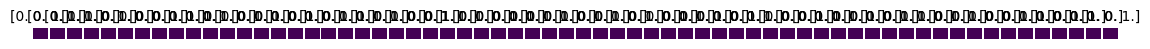

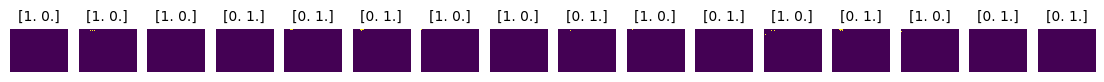

In [ ]:
# Generating and Plot Image Data from Train Set
TRAIN_BATCHES = ImageDataGenerator(rescale=NORMALIZER).\
    flow_from_directory(TRAIN_DIR,
    color_mode='grayscale',
    target_size=INPUT_DIM[0:2],
    classes=classes['TRAIN'],
    class_mode="categorical",
    shuffle=True,
    batch_size=BATCH_SIZE_TRAIN)

imgs, labels = next(TRAIN_BATCHES)  # <-- Extracting image matrixes and labels
plots(imgs, titles=[str(x) for x in labels])
#plots(imgs, titles=labels)          # <-- Plot Images with labels
#train_imgs = rgb_to_grayscale(imgs) # <-- Convert RGB images to Grayscale ones by Tensorflow
#train_labels = labels

# Generating and Plot Image Data from Test Set
TEST_BATCHES = ImageDataGenerator(rescale=NORMALIZER).\
    flow_from_directory(TEST_DIR,
    color_mode='grayscale',
    target_size=INPUT_DIM[0:2],
    classes=classes['TEST'],
    class_mode="categorical",
    shuffle=True,
    batch_size=BATCH_SIZE_TEST)

imgs, labels = next(TEST_BATCHES)   # <-- Extracting image matrixes and labels
plots(imgs, titles=[str(x) for x in labels])
#plots(imgs, titles=labels)          # <-- Plot Images with labels
#test_imgs = rgb_to_grayscale(imgs)  # <-- Convert RGB images to Grayscale ones by Tensorflow
#test_labels = labels

# Generating and Plot Image Data from Validation Set
VAL_BATCHES = ImageDataGenerator(rescale=NORMALIZER).\
    flow_from_directory(VALID_DIR,
    color_mode='grayscale',
    target_size=INPUT_DIM[0:2],
    classes=classes['VALIDATION'],
    class_mode="categorical",
    shuffle=True,
    batch_size=BATCH_SIZE_VALID)

imgs, labels = next(VAL_BATCHES)   # <-- Extracting image matrixes and labels
plots(imgs, titles=[str(x) for x in labels])
#plots(imgs, titles=labels)         # <-- Plot Images with labels
#val_imgs = rgb_to_grayscale(imgs)  # < -- Convert RGB images to Grayscale ones by Tensorflow
#val_labels = labels

In [ ]:
# Output of Generators
for data_batch, label_batch in TRAIN_BATCHES:
    print('data batch shape = {}'.format(data_batch.shape))
    print('labels batch shape = {}'.format(label_batch.shape))
    break

data batch shape = (64, 333, 250, 1)
labels batch shape = (64, 3)


## 3) Build CNN model

In [ ]:
from keras.models import Sequential # Importing the Sequential object from Keras
from keras.layers import Conv2D, Activation, MaxPooling2D, Flatten, Dense # Importing relevant layers
from keras import regularizers
# Build the CNN model
model = Sequential()
model.add(Conv2D(64, (5, 5), input_shape=(INPUT_DIM)))
model.add(Activation('relu'))
model.add(MaxPooling2D((3, 3)))

model.add(Conv2D(128, (4, 4)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (2, 2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, kernel_regularizer=regularizers.l2(0.02)))
model.add(Activation('relu'))

model.add(Dense(3))
model.add(Activation('softmax'))

In [ ]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 329, 246, 64)        │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 329, 246, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 109, 82, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 106, 79, 128)        │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 106, 79, 128)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 53, 39, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 51, 37, 512)         │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 51, 37, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 25, 18, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 23, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 23, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 11, 8, 512)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 9, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 9, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 4, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 3, 2, 512)           │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 3, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 6,756,099 (25.77 MB)

 Trainable params: 6,756,099 (25.77 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Define an optimizer for the model
opt = Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#opt = SGD(lr=0.01, decay=1e-6, momentum=0.85, nesterov=True)
#opt = RMSprop(lr=0.001, rho=0.8, epsilon=None, decay=0.0)

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=opt)

In [ ]:
print('steps_per_epoch={}'.format(int(5215 / BATCH_SIZE_TRAIN)))
print('validation_steps={}'.format(int(624 / BATCH_SIZE_TEST)))

steps_per_epoch=81
validation_steps=9


## 4) Train CNN model

In [ ]:
%%time
model.fit(
    TRAIN_BATCHES,
    steps_per_epoch=len(TRAIN_BATCHES),
    validation_data=TEST_BATCHES,
    validation_steps=len(TEST_BATCHES),
    epochs=100,
    verbose=2
)

## 5) Download Build model file as h5.

In [ ]:

# Save the Model Weights
model.save_weights('model_100_eopchs_adam_20191030_01.h5')

# Save the Model to JSON
model_json = model.to_json()
with open('model_adam_20191030_01.json', 'w') as json_file:
    json_file.write(model_json)

print('Model saved to the disk.')

# Check the build model




In [ ]:
# ------------------------------------------------------------------------
# Load saved model and its weights
'''
>> Model weights are saved to HDF5 format.
>> The model structure can be described and saved using two different formats: JSON and YAML.
'''

# Import dependencies
from keras.optimizers import Adam
from tensorflow.keras.models import Sequential, model_from_json
#from tensorflow.keras.models import model_from_json
from tensorflow.python.framework import ops
ops.reset_default_graph()
import h5py
from PIL import Image
import PIL
from vb100_utils import *

In [ ]:
print('h5py version is {}'.format(h5py.__version__))


h5py version is 3.11.0


In [ ]:
import keras
print(keras.__version__)

3.4.1


In [ ]:
# Get the architecture of CNN
json_file = open('/content/model_adam.json')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# Get weights into the model
loaded_model.load_weights('/content/drive/MyDrive/AI models/model_100_eopchs_adam_20190807.h5')

In [ ]:
import os

# Function to get the model size
def get_model_size(model_path):
    return os.path.getsize(model_path)

# Load the model from the .h5 file
model_path = '/content/drive/MyDrive/AI models/model_100_eopchs_adam_20190807.h5'
model_size = get_model_size(model_path)

print(f'Model size: {model_size / (1024 * 1024):.2f} MB')  # Convert bytes to MB


Model size: 21.00 MB


## Load Build Model and check accurancy

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets import mnist  # Example dataset
from tensorflow.keras.utils import to_categorical

# Function to get the model size
def get_model_size(model_path):
    return os.path.getsize(model_path)

# Load the model from the .h5 file
model_path = '/content/drive/MyDrive/AI models/model_100_eopchs_adam_20190807.h5'
#model = load_model(model_path)

# Get the model size
model_size = get_model_size(model_path)
print(f'Model size: {model_size / (1024 * 1024):.2f} MB')  # Convert bytes to MB

# Load a dataset (replace this with your dataset)
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Preprocess the data (adjust according to your model's input requirements)
x_test = x_test.reshape(-1, 342, 257, 1).astype('float32') / 255.0  # Example reshape
y_test = to_categorical(y_test, num_classes=10)  # Adjust num_classes as needed

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)

print(f'Accuracy: {accuracy:.4f}')


In [ ]:

# Define optimizer and run
opt = Adam( beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
loaded_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='rmsprop')


IMG = Image.open('data/val/BACTERIA/person1950_bacteria_4881.jpeg')
print(type(IMG))
IMG = IMG.resize((342, 257))
IMG = np.array(IMG)
print('po array = {}'.format(IMG.shape))
IMG = np.true_divide(IMG, 255)
IMG = IMG.reshape(1, 342, 257, 1)
print(type(IMG), IMG.shape)

predictions = loaded_model.predict(IMG)

print(loaded_model)
predictions_c = loaded_model.predict_classes(IMG)
print(predictions, predictions_c)

In [ ]:
classes = {'TRAIN': ['BACTERIA', 'NORMAL', 'VIRUS'],
           'VALIDATION': ['BACTERIA', 'NORMAL'],
           'TEST': ['BACTERIA', 'NORMAL', 'VIRUS']}

predicted_class = classes['TRAIN'][predictions_c[0]]
print('We think that is {}.'.format(predicted_class.lower()))